In [17]:
import pyBigWig
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [18]:
parent_dir = "/home/skorsak/Data/Single Cell/cell_cycle_data/"

# Define input files
bw_files = {
    "G1": "k562.ATAC.merge.G1.RPGC.bw",
    "S": "k562.ATAC.merge.S.RPKM.bw",
    "G2M": "k562.ATAC.merge.G2M.RPKM.bw"
}

In [26]:
def moving_average(a, window=1000):
    """Efficient moving average using convolution."""
    return np.convolve(a, np.ones(window)/window, mode='valid')

def bin_signal(signal, bin_size):
    n = len(signal)
    n_bins = n // bin_size
    binned = signal[:n_bins * bin_size].reshape(n_bins, bin_size).mean(axis=1)
    return binned

In [27]:
# Define region of interest
chrom = "chr14"  # or just "14" depending on how it's named in your .bw file
start = 0
end = None  # we'll infer the full chromosome length from the first file

bin_size = 10000  # this reduces ~107M points → ~107K
signals = {}
for phase, path in tqdm(bw_files.items()):
    full_path = os.path.join(parent_dir, path)
    bw = pyBigWig.open(full_path)
    if end is None:
        end = bw.chroms(chrom)
    signal = np.array(bw.values(chrom, start, end))
    signal[np.isnan(signal)] = 0
    signal_binned = bin_signal(signal, bin_size)
    signals[phase] = signal_binned
    bw.close()

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:23<00:00,  7.85s/it]


In [28]:
signals['G1'].shape

(10704,)

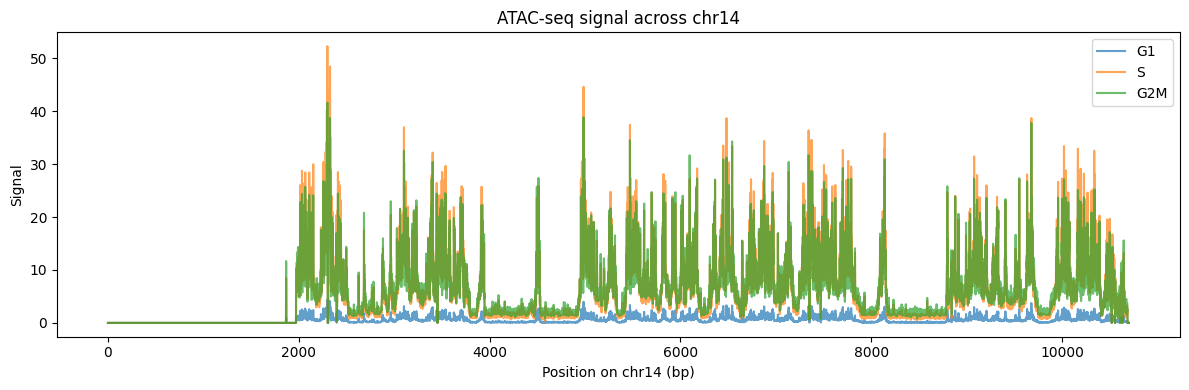

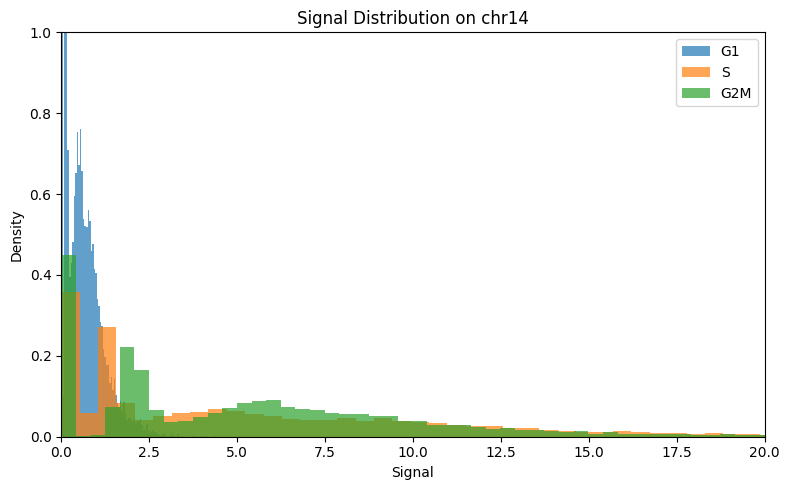

In [36]:
# Plot raw signal comparison
plt.figure(figsize=(12, 4))
for phase, signal in signals.items():
    plt.plot(signal, label=phase, alpha=0.7)
plt.title("ATAC-seq signal across chr14")
plt.xlabel("Position on chr14 (bp)")
plt.ylabel("Signal")
plt.legend()
plt.tight_layout()
plt.show()

# Plot distribution of signal values (histogram)
plt.figure(figsize=(8, 5))
for phase, signal in signals.items():
    plt.hist(signal, bins=100, alpha=0.7, label=phase, density=True)
plt.title("Signal Distribution on chr14")
plt.xlabel("Signal")
plt.xlim((0,20))
plt.ylim((0,1))
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

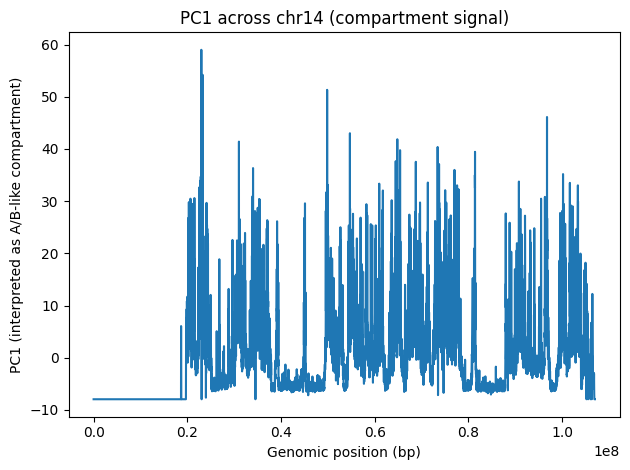

In [38]:
from sklearn.decomposition import PCA

# Shape: samples x bins
matrix = np.vstack([signals[ph] for ph in ["G1", "S", "G2M"]])
pca = PCA(n_components=2)
pcs = pca.fit_transform(matrix.T)  # shape: bins x PCs

plt.plot(x[:len(pcs)], pcs[:, 0])
plt.title("PC1 across chr14 (compartment signal)")
plt.xlabel("Genomic position (bp)")
plt.ylabel("PC1 (interpreted as A/B-like compartment)")
plt.tight_layout()
plt.show()

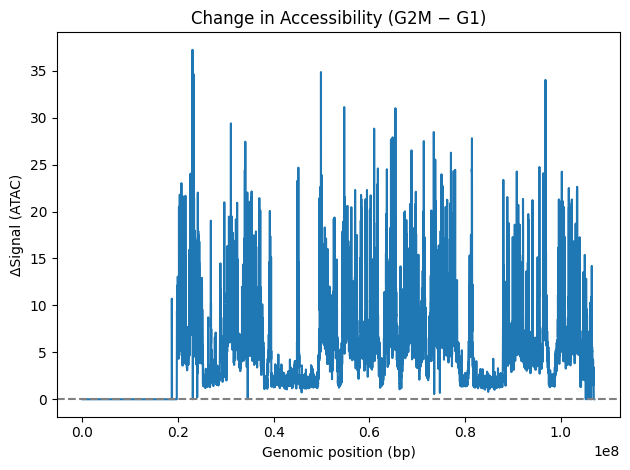

In [39]:
delta = signals["G2M"] - signals["G1"]

plt.plot(x[:len(delta)], delta)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Change in Accessibility (G2M − G1)")
plt.xlabel("Genomic position (bp)")
plt.ylabel("ΔSignal (ATAC)")
plt.tight_layout()
plt.show()

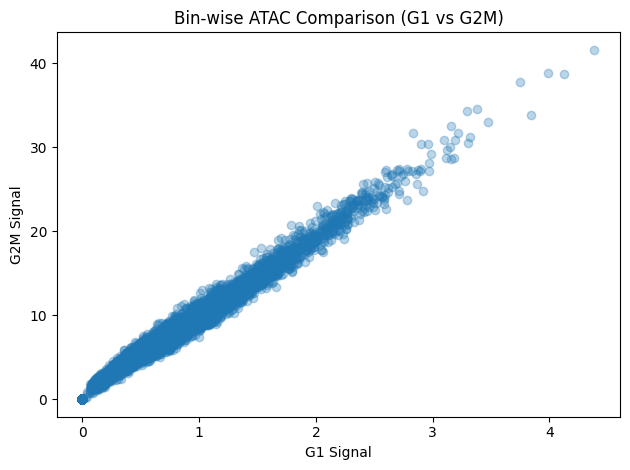

In [40]:
plt.scatter(signals["G1"], signals["G2M"], alpha=0.3)
plt.xlabel("G1 Signal")
plt.ylabel("G2M Signal")
plt.title("Bin-wise ATAC Comparison (G1 vs G2M)")
plt.tight_layout()
plt.show()


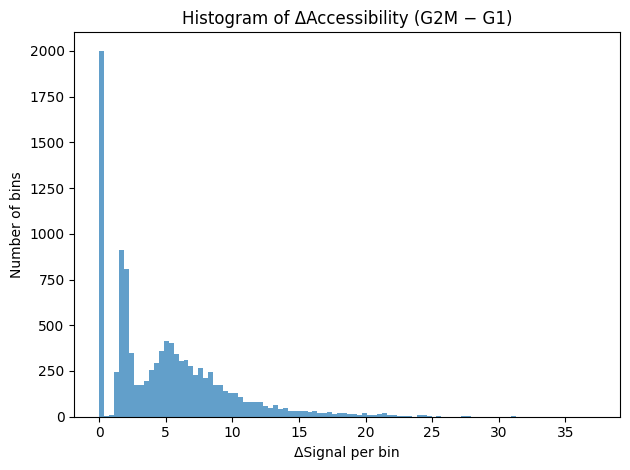

In [41]:
plt.hist(delta, bins=100, alpha=0.7)
plt.title("Histogram of ΔAccessibility (G2M − G1)")
plt.xlabel("ΔSignal per bin")
plt.ylabel("Number of bins")
plt.tight_layout()
plt.show()

In [42]:
from scipy.stats import spearmanr
r_s, _ = spearmanr(signals["G1"], signals["G2M"])
print(f"Spearman correlation (G1 vs G2M): {r_s:.3f}")

Spearman correlation (G1 vs G2M): 0.992


In [43]:
from scipy.stats import spearmanr
r_s, _ = spearmanr(signals["G1"], signals["S"])
print(f"Spearman correlation (G1 vs S): {r_s:.3f}")

Spearman correlation (G1 vs S): 0.994


In [44]:
from scipy.stats import spearmanr
r_s, _ = spearmanr(signals["S"], signals["G2M"])
print(f"Spearman correlation (S vs G2M): {r_s:.3f}")

Spearman correlation (S vs G2M): 0.989
